<a href="https://colab.research.google.com/github/kschoi93/AI/blob/master/%EC%8B%A4%EC%8A%B52_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%95%99%EC%8A%B5_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as vision_dsets
import torchvision.transforms as T
import torch.optim as optim

from torch.autograd import Variable
from torch.utils import data

In [3]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [18]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy =  np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(20, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, '{:0.4f}'.format(cm[i, j]),
                         horizontalalignment='center',
                        color='white' if cm[i, j] > thresh else 'black')
            else:
                plt.text(j, i, '{:,}'.format(cm[i, j]),
                         horizontalalignment='center',
                         color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label \naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
def MNIST_DATA(root='./data', train=True, transforms=None, download=True, batch_size=32, num_worker=1):
    print('[+] Get the MNIST DATA')

    mnist_train = vision_dsets.MNIST(root = root,
                                     train = True,
                                     transform = T.ToTensor(),
                                     download = download)
    mnist_test = vision_dsets.MNIST(root = root,
                                    transform = T.ToTensor(),
                                    download = download)
    
    trainDataLoader = data.DataLoader(dataset = mnist_train,
                                      batch_size = batch_size,
                                      shuffle = True,
                                      num_workers = num_worker)
    
    testDataLoader = data.DataLoader(dataset = mnist_test,
                                     batch_size = batch_size,
                                     shuffle = False,
                                     num_workers = num_worker)
    
    print('[+] Finished loading data & Preprocessing')
    return mnist_train, mnist_test, trainDataLoader, testDataLoader

In [6]:
trainDset, testDset, trainDataLoader, testDataLoader = MNIST_DATA(batch_size = 32, num_worker=1)

[+] Get the MNIST DATA


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[+] Finished loading data & Preprocessing


In [7]:
trainDset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

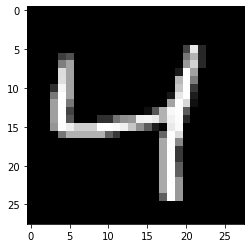

In [8]:
plt.imshow(trainDset.data[2], cmap='gray')

In [9]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 100):
        """
        epoch: number of times each training sample is used
        """
        self.net.train() # net.eval()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data[0], data[1] # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda() # gpu training
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval()
                        # -
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) # 32 * 10
            pred = output.max(1, keepdim=True)[1] # get the index of the max # 32
            correct += pred.eq(labels.view_as(pred)).sum().item() # 0~32

            test_loss /= len(self.testloader.dataset) # 10,000
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
        
    def get_conf(self):
        self.net.eval()
        
        confusion = torch.zeros(10,10)
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            output = self.net(inputs)
            pred = torch.argmax(output, dim=1)
            
            for num in range(output.shape[0]):
                confusion[pred[num], labels[num]] += 1
        
        return confusion

In [10]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = self.act(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [11]:
mnist_net = MNIST_Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [12]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [13]:
trainer.train(epoch = 10)

[1,   500] loss: 2.322
[1,  1000] loss: 2.295
[1,  1500] loss: 2.278
[2,   500] loss: 2.256
[2,  1000] loss: 2.241
[2,  1500] loss: 2.228
[3,   500] loss: 2.203
[3,  1000] loss: 2.189
[3,  1500] loss: 2.174
[4,   500] loss: 2.146
[4,  1000] loss: 2.129
[4,  1500] loss: 2.108
[5,   500] loss: 2.076
[5,  1000] loss: 2.055
[5,  1500] loss: 2.035
[6,   500] loss: 1.996
[6,  1000] loss: 1.970
[6,  1500] loss: 1.948
[7,   500] loss: 1.903
[7,  1000] loss: 1.879
[7,  1500] loss: 1.855
[8,   500] loss: 1.804
[8,  1000] loss: 1.782
[8,  1500] loss: 1.758
[9,   500] loss: 1.707
[9,  1000] loss: 1.683
[9,  1500] loss: 1.653
[10,   500] loss: 1.609
[10,  1000] loss: 1.584
[10,  1500] loss: 1.556
Finished Training


In [14]:
trainer.test()


Test set:  Accuracy: 42386/60000 (71%)



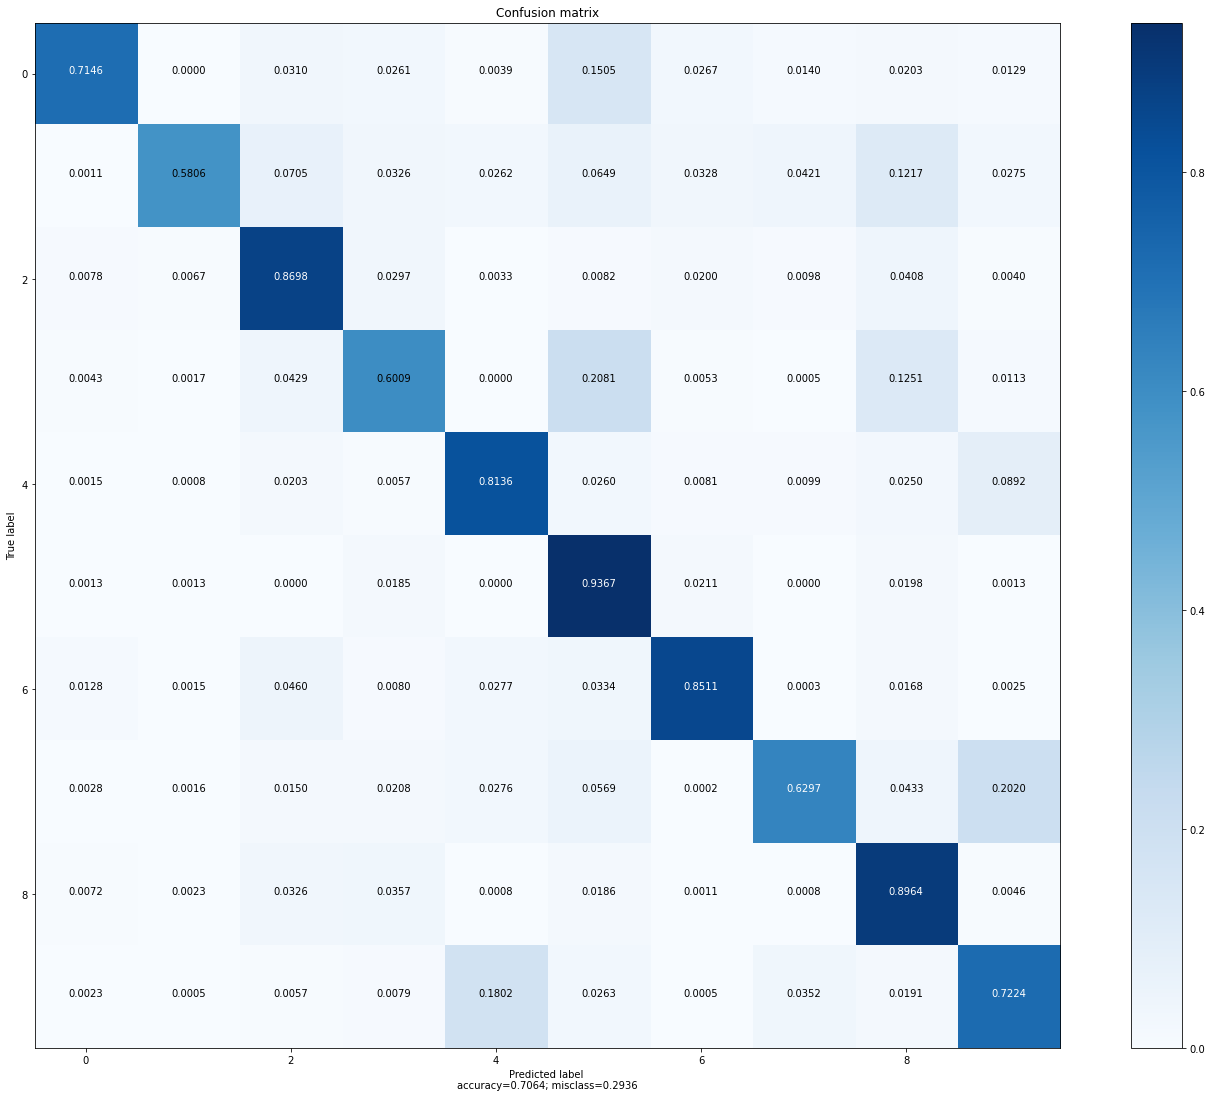

In [19]:
plot_confusion_matrix(trainer.get_conf().numpy())

In [20]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = self.act(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [21]:
mnist_net = MNIST_Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [22]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [23]:
trainer.train(epoch=10)

[1,   500] loss: 2.258
[1,  1000] loss: 2.161
[1,  1500] loss: 2.036
[2,   500] loss: 1.766
[2,  1000] loss: 1.605
[2,  1500] loss: 1.453
[3,   500] loss: 1.220
[3,  1000] loss: 1.105
[3,  1500] loss: 1.018
[4,   500] loss: 0.894
[4,  1000] loss: 0.830
[4,  1500] loss: 0.786
[5,   500] loss: 0.720
[5,  1000] loss: 0.693
[5,  1500] loss: 0.654
[6,   500] loss: 0.619
[6,  1000] loss: 0.606
[6,  1500] loss: 0.587
[7,   500] loss: 0.555
[7,  1000] loss: 0.546
[7,  1500] loss: 0.534
[8,   500] loss: 0.513
[8,  1000] loss: 0.499
[8,  1500] loss: 0.490
[9,   500] loss: 0.475
[9,  1000] loss: 0.472
[9,  1500] loss: 0.467
[10,   500] loss: 0.455
[10,  1000] loss: 0.454
[10,  1500] loss: 0.446
Finished Training


In [24]:
trainer.test()


Test set:  Accuracy: 53041/60000 (88%)



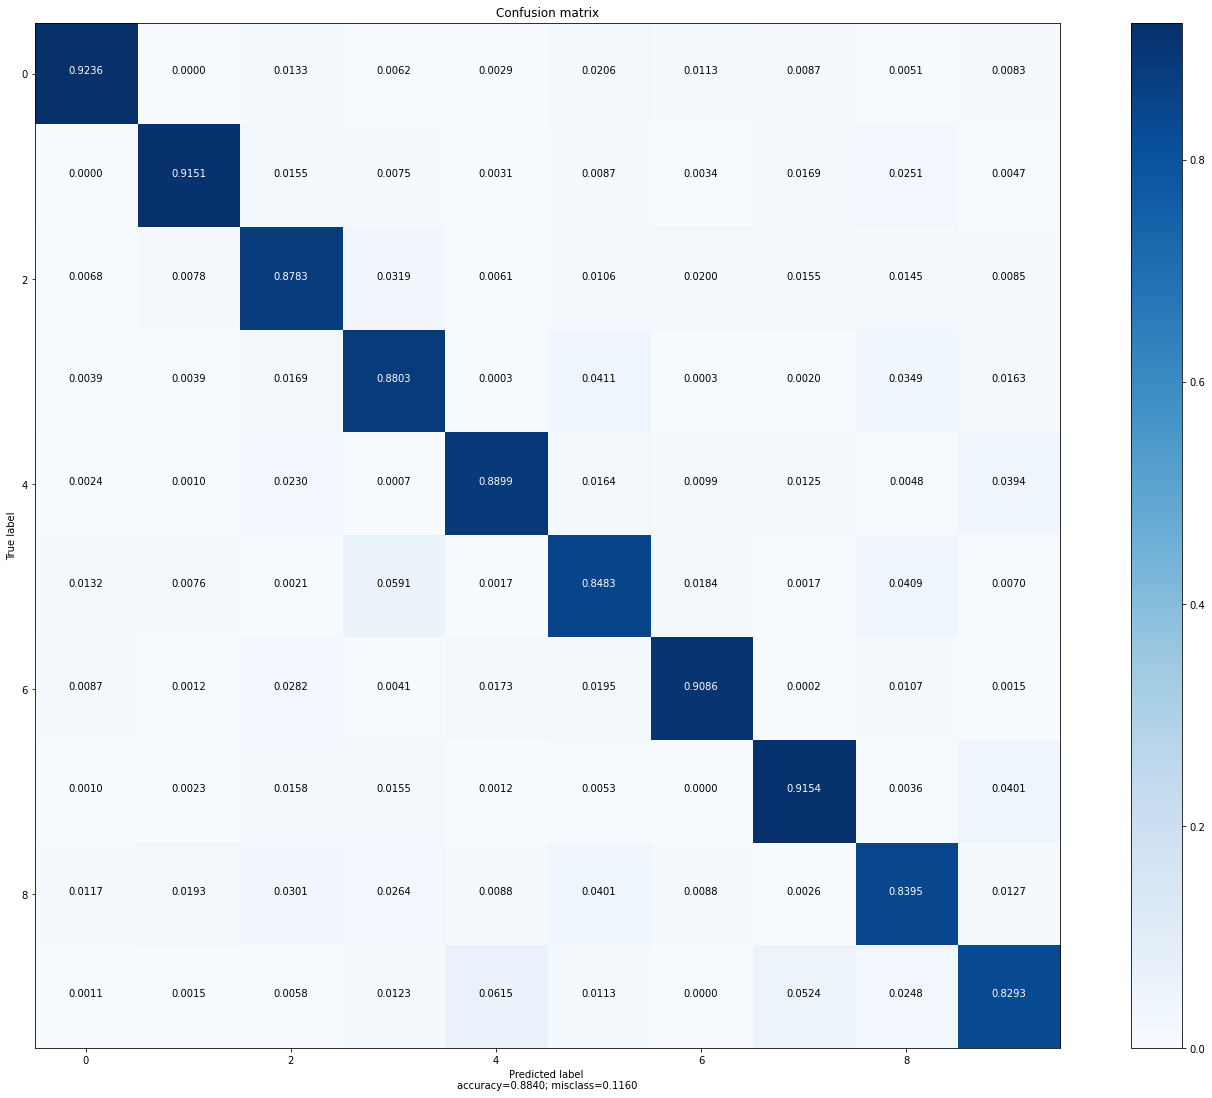

In [25]:
plot_confusion_matrix(trainer.get_conf().numpy())